# Notebook de Entrenamiento de Algoritmos para despliegue en BentoML
Este notebook consistirá en la creación y entrenamiento de nuestros de algoritmos aplicados a nuestro dataset **ai4i2020** para predecir/clasificar fallos maquinarios. Intercalando código y explicación, trataremos con diferentes algoritmos de diferente dificultad para contrastar resultados y dejar todos preparados para ser desplegados mediante la API creada en una interfaz gráfica creada mediante **Streamlit**.

Cabe objetar que intentaremos desplegar el código de la mejor forma para su futura reutilización en otras partes del proyecto, siguiendo fomrmato similar al visto en clase. Las visualizaciones como la de las matrices de confusión se ejecutarán directamente en este notebook para una mejor interpretación, y se guardarán igualmente dentro de los metadatos del modelo formato BentoML.

## Dependencias

In [1]:
# Librerías más generales
import bentoml
import json
from datetime import datetime
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

# Métricas de evaluación que usaremos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, roc_curve

# Visualización
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Algoritmos que probaremos
from sklearn.linear_model import LogisticRegression # fallo/no fallo
from sklearn.ensemble import RandomForestClassifier # clasificación de errores
from sklearn import svm # Support vector machines para clasificación
from sklearn.cluster import HDBSCAN # Algoritmo para clasificación por densidad

# XGBoost
from xgboost import XGBClassifier


## 1. Algoritmos de Regresión
Mediante los algoritmos regresivos que probaremos, intentaremos realizar las mejores predicciones posibles para intentar anticiparnos al fallo de nuestras máquinas sintéticas. Ya que la variable que nos interesa (**Machine failure**) tiene un output binario de 0 (no ha habido fallo) o de 1 (ha habido fallo), nos hemos decantado por realizar una regresión logística primero. 

### 1.1 Regresión Logística
Intentaremos predecir el output binario que indica si el proceso ha fallado o no, mediante una implementación básica de este primer algoritmo de regresión.

In [2]:
# Para cada algoritmo haremos una función diferente; creando un modelo diferente para la model store, nombre diferente, ...
def logistic_regression():
    dataset = pd.read_csv("../../data/ai4i2020.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X, y = dataset.drop(columns=["UDI", "Machine failure"]), dataset["Machine failure"] 

    # Pasamos a númericas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    # Dividimos el dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    # Inicializamos el modelo de regresión logística
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    # Realizamos las predicciones
    preds = lr.predict(X_test)

    # Métricas de evaluación
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy obtenida: {accuracy:.4f}")

    precision = precision_score(y_test, preds)
    print(f"Precisión obtenida: {precision:.4f}")

    recall = recall_score(y_test, preds)
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(y_test, preds)
    print(f"F1: {f1:.4f}")

    # Matriz de confusión
    confusion_mat = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_mat)
    disp.plot()
    plt.title("Confusion Matrix de nuestra Regresión Logística")
    plt.show()

    # Plot de Curva ROC
    y_prob = lr.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Curva ROC (Valor AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  
    plt.title("Curva ROC para la Regresión Logística")
    plt.legend()
    plt.grid(True)
    plt.show()

    # A partir de ahora, configuraremos el modelo para que sea compatible con BentoML
    bento_lr = bentoml.sklearn.save_model(
        "ai4i2020_logistic_regression",
        lr,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "regresión logística",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": confusion_mat,
            "auc_score": auc_score,
            "carta_favorita_cr": "Reina Arquera MOMO SHOW"
        },
    )
    print(f"Modelo de Regresión Logística guardado en la BentoML store como: {bento_lr}")

Y lo ejecutamos corriendo esta simple celda:

/home/unai/miniconda3/envs/rl/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy obtenida: 0.9960
Precisión obtenida: 1.0000
Recall: 0.8689
F1: 0.9298


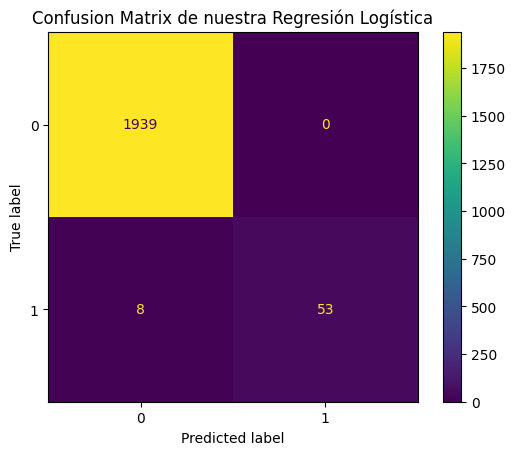

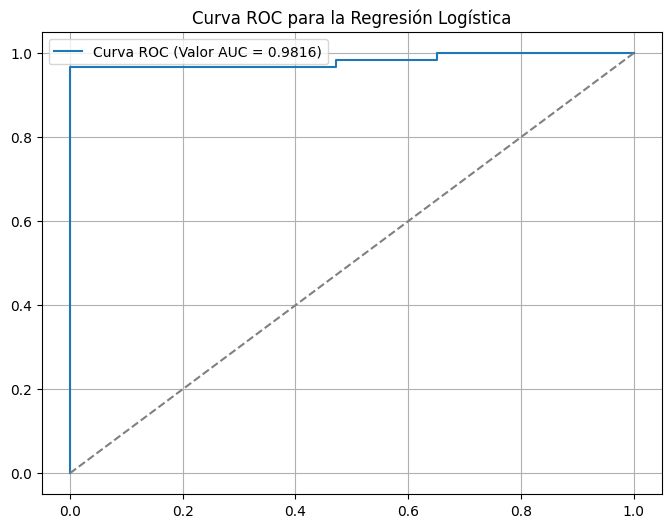

/home/unai/miniconda3/envs/rl/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


Modelo de Regresión Logística guardado en la BentoML store como: Model(tag="ai4i2020_logistic_regression:nsn576gqlssdz7fk")


In [3]:
logistic_regression()

## 2. Algoritmos de Clasificación
En esta segunda sección de algoritmos, en vez de predecir el resultado del proceso maquinario, intentaremos clasificar el fallo (en el caso de que haya habido) dentro de los distintos tipos de fallas.

### 2.1 Random Forest
Mediante el random forest intentaremos clasificar los errores de los procesos sintéticos en los 5 tipos de errores que existen y enlista nuestro dataset:
- TWF: Fallo por desgaste de herramienta.
- HDF: Fallo por una mala disipación de calor.
- PWF: Falla por potencia fuera de rango.
- OSF: Fallo por un sobreesfuerzo mecánico.
- RNF: Un fallo aleatorio.
Ya que con este clasificador no vamos a tratar una clasificación binaria, sino una multiclase, tendremos que cambiar algunos parametros de métricas. Y usaremos el **weighted** para el f1-score.

In [5]:
def random_forest():
    dataset = pd.read_csv("../../data/ai4i2020.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X, y = dataset.drop(columns=["UDI", "Machine failure", "TWF", "HDF", "PWF", "RNF", "OSF"]), dataset[["TWF", "HDF", "PWF", "RNF", "OSF"]]

    # Pasamos a númericas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    # Dividimos el dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    # Inicializamos el modelo de regresión logística
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Realizamos las predicciones
    preds = rf.predict(X_test)

    # Por ahora solo tendremos como métrica de evaluación la accuracy
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy obtenida: {accuracy:.4f}")

    precision = precision_score(y_test, preds, average='weighted')
    print(f"Precisión obtenida: {precision:.4f}")

    recall = recall_score(y_test, preds, average='weighted')
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(y_test, preds, average='weighted')
    print(f"F1: {f1:.4f}")

    # A partir de ahora, configuraremos el modelo para que sea compatible con BentoML
    bento_rf = bentoml.sklearn.save_model(
        "ai4i2020_random_forest",
        rf,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "clasificación con random forest",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "carta_favorita_cr": "Reina Arquera MOMO SHOW"
        },
    )
    print(f"Modelo de Clasificación con Random Forest guardado en la BentoML store como: {bento_rf}")

Para ejecutar el Random Forest:

In [6]:
random_forest()

Accuracy obtenida: 0.9705
Precisión obtenida: 0.5000
Recall: 0.1389
F1: 0.1930


/home/unai/miniconda3/envs/rl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Modelo de Clasificación con Random Forest guardado en la BentoML store como: Model(tag="ai4i2020_random_forest:p5jmvcwqlssdz7fk")


### 2.2 Suppor Vector Machines (SVMs)
Este algoritmo de clasificación más pesado buscará separar las observaciones donde haya habido fallo y donde no en un espacio mediante el empleo de vectores clasificadores. Es decir, volveremos a emplear como variable 'y' la variable de **Machine Failure**.

In [ ]:
def support_vector_machines():
    dataset = pd.read_csv("../../data/ai4i2020.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X, y = dataset.drop(columns=["UDI", "Machine failure"]), dataset["Machine failure"]

    # Pasamos a numéricas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    # Escalado con StandardScaler()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Distribución train/test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, random_state=42)

    # SVM mejorado
    model_svm = svm.SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True
    )
    model_svm.fit(X_train, y_train)

    # Predicciones
    preds = model_svm.predict(X_test)

    # Métricas
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy obtenida: {accuracy:.4f}")

    precision = precision_score(y_test, preds)
    print(f"Precisión obtenida: {precision:.4f}")

    recall = recall_score(y_test, preds)
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(y_test, preds)
    print(f"F1: {f1:.4f}")
    
    # Matriz de confusión
    confusion_mat = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_mat)
    disp.plot()
    plt.title("Confusion Matrix de nuestra Clasificación con SVMs")
    plt.show()

    # Plot de los SVMs
    pca = PCA(n_components=2)
    X_test_pca = pca.fit_transform(X_test)

    # Reentrenamos el modelo usando los componentes PCA
    svm_pca = svm.SVC(kernel='rbf', probability=True)
    svm_pca.fit(pca.transform(X_train), y_train)

    # Crear una malla para dibujar la frontera de decisión
    x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
    y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    '''
    # Plot final
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="coolwarm", s=20, edgecolor="k")
    plt.title("Plot de las SVMs en un espacio bidimensional (con PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    '''

    # A partir de ahora, configuraremos el modelo para BentoML
    bento_svm = bentoml.sklearn.save_model(
        "ai4i2020_support_vector_machine",
        model_svm,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "clasificación con svms",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": confusion_mat,
        },
    )

    print(f"Modelo de SVM guardado como: {bento_svm}")


Ejecutémoslo:

In [ ]:
support_vector_machines()

### 2.3 XGBoost (XGBClassifier)
Siguiendo con los algoritmos de clasificación, vamos a tratar finalmente con uno especializado y optimizado para los datasets tabulares como el nuestro: el **XGBClassifier**. A diferencia de otros algoritmos, **XGBoost** es sensible a ciertos caracteres conflictivos, por lo que nos hemos visto forzados a eliminar o limpiar estos.

In [10]:
def xgb_classifier():
    dataset = pd.read_csv("../../data/ai4i2020.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X, y = dataset.drop(columns=["UDI", "Machine failure"]), dataset["Machine failure"] 

    # Pasamos a númericas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    # Eliminamos los caracteres conflictivos para que nuestro clasificador funcione correctamente
    X.columns = (X.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.replace('<', '', regex=False))

    # Dividimos el dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    xgbc = XGBClassifier(eval_metric="logloss")
    xgbc.fit(X_train, y_train)

    # Realizamos las predicciones
    preds = xgbc.predict(X_test)

    # Por ahora solo tendremos como métrica de evaluación la accuracy
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy obtenida: {accuracy:.4f}")

    precision = precision_score(y_test, preds)
    print(f"Precisión obtenida: {precision:.4f}")

    recall = recall_score(y_test, preds)
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(y_test, preds)
    print(f"F1: {f1:.4f}")

    confusion_mat = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_mat)
    disp.plot()
    plt.title("Confusion Matrix de nuestra Clasificación con XGBoostClassifier")
    plt.show()

    # Plot de Curva ROC
    y_prob = xgbc.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Curva ROC (Valor AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  
    plt.title("Curva ROC para la Regresión Logística")
    plt.legend()
    plt.grid(True)
    plt.show()

    # A partir de ahora, configuraremos el modelo para que sea compatible con BentoML
    bento_xgbc = bentoml.sklearn.save_model(
        "ai4i2020_xgbclassifier",
        xgbc,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "clasificación con xgbclassifier",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": confusion_mat,
            "carta_favorita_cr": "Reina Arquera MOMO SHOW"
        },
    )
    print(f"Modelo de Clasificación con XGBoostClassifier guardado en la BentoML store como: {bento_xgbc}")

Accuracy obtenida: 0.9990
Precisión obtenida: 1.0000
Recall: 0.9672
F1: 0.9833


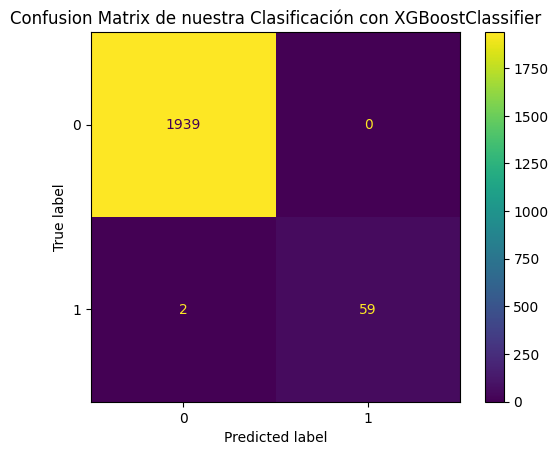

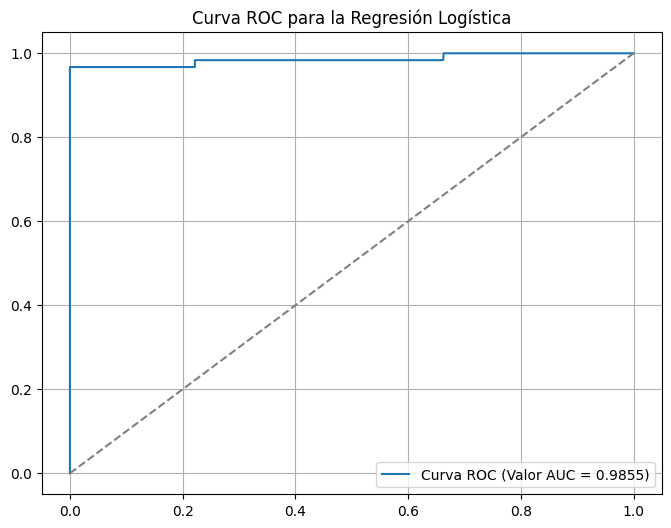

Modelo de Clasificación con XGBoostClassifier guardado en la BentoML store como: Model(tag="ai4i2020_xgbclassifier:5aqyb5wqlssdz7fk")


In [11]:
xgb_classifier()

# 3. Algoritmos de Agrupación (Clustering)
Aunque el análisis más interesante para nuestro caso se encuentre en los dos tipos de algoritmos previamente analizados, también podemos intentar encontrar patrones de agrupación de fallas en nuestro dataset. Para esto, usaremos un simple algoritmo de agrupación como **HDBSCAN**.

### 3.1 HDBSCAN
Vamos a implementar un algoritmo de agrupación basado en densidad, es decir, va a formar subgrupos basados en la densidad (o número de instancias) de éstos. Por otra parte, como tratamos de un tipo de algoritmo totalmente diferente al resto, tendremos que usar métricas de evaluación diferentes.

In [12]:
def hdbscan_clustering():
    dataset = pd.read_csv("../../data/ai4i2020.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X = dataset.drop(columns=["UDI", "Machine failure", "TWF", "HDF", "PWF", "RNF", "OSF"], errors='ignore')

    # Pasamos a númericas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    # Eliminamos caracteres conflictivos de nombres de columnas, como con el xgboostclassifier
    X.columns = (X.columns.str.replace("[", "", regex=False).str.replace("]", "", regex=False).str.replace("<", "", regex=False))

    # Para que las variables, como la distancia entre clusters por ejemplo, sea fidedigna, habrá que escalar y normalizar los datos primero, usaremos un simple StandardScaler()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Creamos HDBSCAN
    hdb = HDBSCAN(min_cluster_size=3) # Inicializamos el tamaño mínimo de la agrupación como 3
    labels = hdb.fit_predict(X_scaled) # De aquí sacamos las predicciones de labels que dirán a qué cluster pertenece cada observación

    # Resultados (número total de clusters)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Número de clusters encontrados (excluyendo ruido): {n_clusters}")

    # Métrica de evaluación específica para clustering: Silhouette score (calidad del cluster)
    silouhette = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_score:.4f}")

    # Visualización 2D con PCA; reduciremos la dimensionalidad de nuestro dataset a 2 dimensiones para una más clara visualización
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=15, alpha=0.8)
    plt.title("HDBSCAN clustering (PCA 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    bento_hdbscan = bentoml.sklearn.save_model(
        "ai4i2020_xgbclassifier",
        hdb,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "agrupación (clustering) con HDBSCAN",
            "silhouette_score": silouhette,
            "carta_favorita_cr": "Reina Arquera MOMO SHOW"
        },
    )
    print(f"Modelo de Clustering con HDBSCAN guardado en la BentoML store como: {bento_hdbscan}")


In [ ]:
hdbscan_clustering()

## Para alistar los modelos creados en la BentoML Store:
Al ejecutar el siguiente comando, podremos ver datos sobre el modelo como su nombre (con su tag), el módulo usado, el tamaño final del modelo y la fecha de creación del modelo. Cada vez que ejecutemos una función que llame al entrenamiento de un algoritmo, se creará otro con un tag distinto. Pudiendo haber más de una instancia por algoritmo, el tag los diferenciará. En el caso de que queramos eliminar una instancia, tendremos que usar el siguiente comando:

```bash
bendoml models delete <nombre del modelo (con su tag)>
```
Usaré el siguiente comando para alistar todos los modelos creados y disponibles en la BentoML Store.

In [13]:
!bentoml models list 

/home/unai/miniconda3/envs/rl/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
 Tag                           Module           Size        Creation Time       
 ai4i2020_xgbclassifier:5aqy…  bentoml.sklearn  491.98 KiB  2025-12-03 16:29:49 
 ai4i2020_random_forest:p5jm…  bentoml.sklearn  22.69 MiB   2025-12-03 16:26:54 
 ai4i2020_logistic_regressio…  bentoml.sklearn  275.50 KiB  2025-12-03 16:26:22 
 ai4i2020_random_forest:26wd…  bentoml.sklearn  22.24 MiB   2025-12-03 16:07:53 
 ai4i2020_logistic_regressio…  bentoml.sklearn  275.50 KiB  2025-12-03 16:07:22 
 ai4i2020_suppor_vector_mach…  bentoml.sklearn  43.36 MiB   2025-12-03 16:02:52 
 ai4i2020_suppor_vector_mach…  bentoml.s